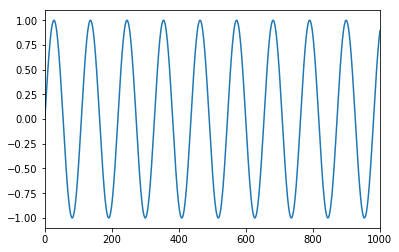

In [76]:
# https://www.pythonforengineers.com/audio-and-digital-signal-processingdsp-in-python/
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import wave
import struct 
import matplotlib.pyplot as plt
import astropy.units as u
# frequency is the number of times a wave repeats a second
 
frequency = 440 * u.Hz
sampling_rate = 48000 * u.Hz 
duration = 5 * u.s
num_samples = int(duration * sampling_rate)

# The sampling rate of the analog to digital convert

amplitude = 20000
file = "test.wav"

x = np.arange(0, num_samples)
sine_wave = np.sin(2 * np.pi * float(frequency/sampling_rate) * x)

def write_wave(waveform, num_samples, sampling_rate, path='test.wav'):
    nframes=num_samples
    comptype = "NONE"
    compname = "not compressed" 
    nchannels = 1
    sampwidth = 2 

    plt.plot(np.arange(len(waveform)), waveform)
    plt.xlim([0, x[1000]])
    plt.show()

    with wave.open(path, 'w') as wav_file:

        wav_file.setparams((nchannels, sampwidth, int(sampling_rate.value), nframes, comptype, compname))

        for s in waveform:
            wav_file.writeframes(struct.pack('h', int(s*amplitude)))

write_wave(sine_wave, num_samples, sampling_rate)

In [96]:
from astropy.io import fits

d = fits.getdata('data/nPLDTrappist.fits')

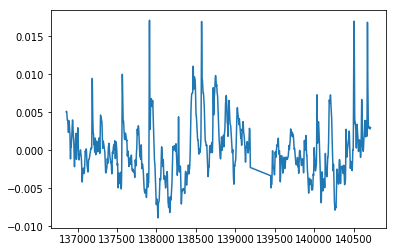

In [97]:
from scipy.ndimage import gaussian_filter1d

time, flux = d['CADN'], d['FLUX']

flux /= flux.mean()

condition = (flux > 0.9) & (flux < 1.1) & (~np.isnan(flux)) & (~np.isnan(time))
fit = np.polyval(np.polyfit(time[condition], flux[condition], 3), time[condition])
time = time[condition]
flux = flux[condition] - fit

flux = gaussian_filter1d(flux, 3)

plt.plot(time, flux)

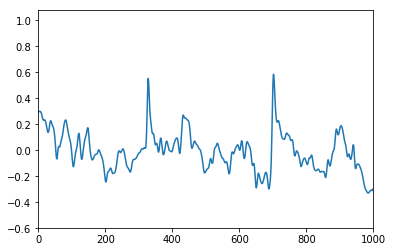

In [98]:
flux = np.tile(flux / flux.max(), 100)

write_wave(flux, len(flux), sampling_rate)